# 6.6.5 Estudio de Caso: Diagnóstico del cáncer de seno usando kNN

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

link: https://www.youtube.com/watch?v=KisMuZYgg0E

Fuente de los datos: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

Bibliografía: Machine Learning with R. Brett Lantz, Packt Publishing, Second Edition, 2015.

## 6.6.5.1 Descripción del problema

Se desea determinar si una masa mamaria es un tumor benigno o maligno, a partir de las medidas obtenidas de imágenes digitalizadas de la aspiración con una aguja fina. Los valores representan las características de los núcleos celulares presentes en la imagen digital. La muestra de 569 ejemplos de resultados de las biopsias. Cada registro contiene 32 variables, las cuales corresponden a tres medidas (media, desviación estándar, peor caso) de diez características diferentes (radius, texture, …).

- Identification number
- Cancer diagnosis ("M" para maligno y "B" para benigno)
- Radius
- Texture
- Perimeter
- Area
- Smoothness
- Compactness
- Concavity
- Concave points
- Symmetry
- Fractal dimension

En términos de los datos, se desea pronosticar si una masa es benigna o maligna (clase B o M) a partir de las 30 variables.

El problema en términos matemáticos se define de la siguiente forma.

- Se tienen $M$ ejemplos (las 569 observaciones del problema analizado).
- Cada ejemplo esta definido por un conjunto de variables ($x_1, $x_2$, …, $x_N$); es decir, las 30 columnas de datos.
- Cada ejemplo pertenece a una clase y hay $P$ clases diferentes; en el caso analizado sólo hay dos clases: benigno o maligno.
- Para un nuevo caso (tumor) y con base en las 30 mediciones realizadas (variables), se desea pronosticar a que clase pertenece (maligno o benigno).

## 6.6.5.2 Carga de datos

In [13]:
columns = ['radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean',
'compactness_mean','concavity_mean','concave_points_mean','symmetry_mean','fractal_dimension_mean',
'radius_se','texture_se','perimeter_se','area_se','smoothness_se','compactness_se','concavity_se',
'concave_points_se','symmetry_se','fractal_dimension_se','radius_worst','texture_worst',
'perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst',
'concave_points_worst','symmetry_worst','fractal_dimension_worst']

# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

X.columns = columns
y.columns = ['diagnosis']

print(breast_cancer_wisconsin_diagnostic.metadata) 
print(breast_cancer_wisconsin_diagnostic.variables) 

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'published_in': 'Electronic imaging', 'year': 1993, 'url': 'https://www.semanticscholar.org/paper/53

In [15]:
#
# Verificación de los datos cargados
#  La columna diagnosis corresponde al dianóstico.
#
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave_points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

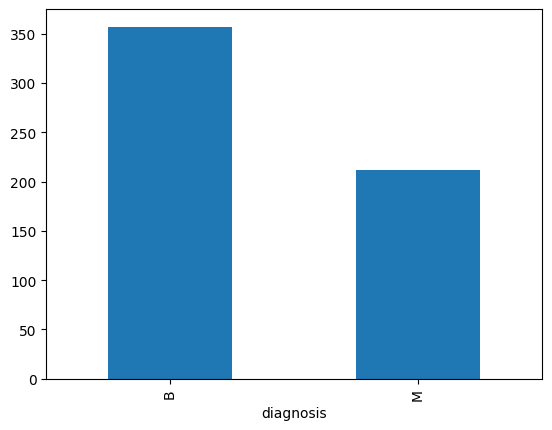

In [16]:
#
# Cantidad de casos para cada diagnóstico.
#
y.diagnosis.value_counts().plot.bar();

In [17]:
#
# Cantidad de casos para cada diagnóstico.
#
y.diagnosis.value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

In [18]:
#
# Probabilidades.
#
round(100 * y.diagnosis.value_counts() / sum(y.diagnosis.value_counts()), 1)

diagnosis
B    62.7
M    37.3
Name: count, dtype: float64

## 6.6.5.3 Preparación de los datos

In [20]:
#
#  se examina el rango de las variables
#
X.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


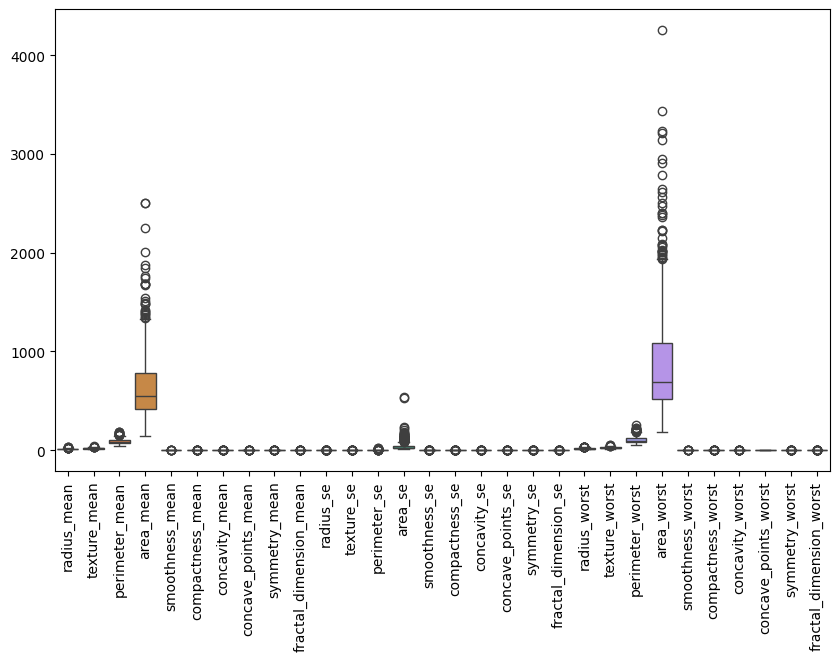

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=X)
plt.xticks(rotation=90);

Note que la información visualizada muestra que las variables tienen diferentes rangos, lo que afecta la medición de las distancias, y habría variables que pesarían más en la medición respecto a otras. Para corregir este problema se normalizan las variables.

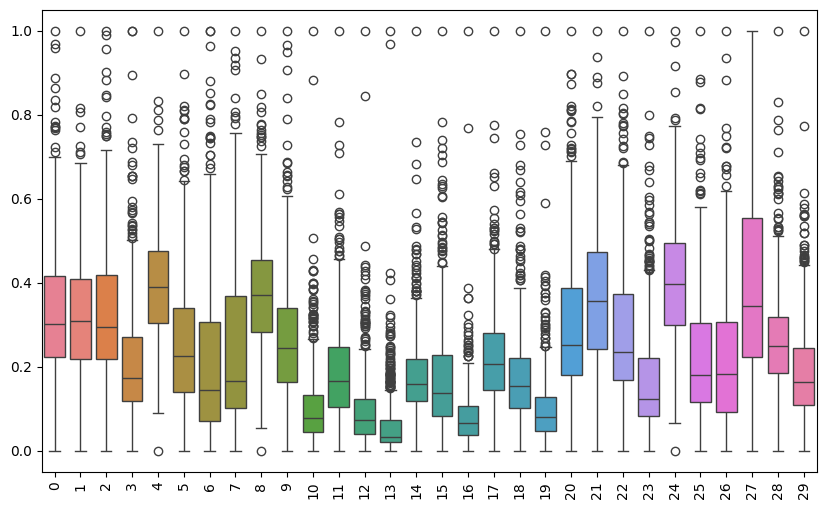

In [24]:
#
# Escala la matriz de datos al intervalo [0, 1]
#
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_scaled)
plt.xticks(rotation=90);

## 6.6.5.4 Entrenamiento del modelo

In [25]:
#
# Se crean los conjuntos de entrenamiento y prueba
#
X_train = X_scaled[:468]
X_test = X_scaled[468:]
y_train_true = y[:468]
y_test_true = y[468:]

In [27]:
parameters = [{"n_neighbors": np.arange(1, 25)}]

estimator = GridSearchCV(
    KNeighborsClassifier(),
    parameters,
    cv=10,
)

estimator.fit(X_train, y_train_true)

y_test_pred = estimator.predict(X_test)

confusion_matrix(y_test_true, y_test_pred)

array([[72,  5],
       [ 1, 23]], dtype=int64)

In [28]:
#
# Cantidad optima de vecinos
#
estimator.best_params_

{'n_neighbors': 3}

In [ ]:
print('ok_')

ok_
